# Steam Library Analyzer
## GitHub repository: [https://github.com/saulTejeda117/Steam-Data-Analyzer](https://github.com/saulTejeda117/Steam-Data-Analyzer)

Steam Library Analyzer es un projecto de ciencia de datos enfocado principalmente en el analisis predictivo de los habitos de juego de los usuarios de [_`Steam`_](https://store.steampowered.com). Su objetivo principal es determinar el tiempo estimado para completar todos los juegos de la biblioteca de un jugador. Para ello se ha hecho uso de fuentes de información tales como la WEB dedicada a videojuegos [_`How Long To Beat`_](https://howlongtobeat.com) y la [_`Steam API`_](https://steamcommunity.com/dev) que hacen posible acceder a información necesaria como:

- **Completion Rate:** Es la métrica que indica la proporción de juegos que un jugador ha completado en comparación con el total de juegos en su biblioteca.
  
- **Total games:** Hace referencia a la cantidad total de juegos que un usuario tiene actualmente en su biblioteca de juegos de Steam.
  
- **Perfect Games:** Se refiere aquellosjuegos cuyas metas y logros han sido alcanzados al 100%, según las estadísticas proporcionadas por Steam.

<img src="SteamAnalyzerCover2.jpg">


</img>

<hr>

In [1]:
import requests
import json
import time
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

## Obtain User Steam Profile Data

El proceso de análisis se inicia mediante la obtención de la información esencial de la cuenta de usuario que se pretende evaluar. En este sentido, se procede a extraer los datos pertinentes del archivo _JSON_ denominado  _`"steam_credentials.json"`_, dicho archivo alberga información crucial, incluyendo:

- **Steam API key:** son identificadores únicos e irrepetibles proporcionados por Steam a desarrolladores y aplicaciones que desean acceder a la Steam API.
  
- **Steam ID:** se refiere a un identificador único utilizado para identificar de manera única a los usuarios y sus perfiles en la plataforma Steam.

In [2]:
# Load the steam credentials JSON file 
with open('steam_credentials.json') as json_file:
    credentials = json.load(json_file)

api_key = credentials.get('api_key')
steam_id = credentials.get('steam_id')

Posteriormente se realiza una consulta a la [_`Steam API`_](https://steamcommunity.com/dev) para obtener los datos de la cuenta de usuario al que pertecenen las credenciales ingresadas. Se comprueba la  respuesta de la petición.


In [3]:
# Obtener la URL de la información del jugador utilizando la API de Steam
player_info_url = f'http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key={api_key}&steamids={steam_id}'
response = requests.get(player_info_url)

if (response != None):
    data = response.json()
    # print(data, "\n\n\n")
    print("Username: ", data['response']['players'][0]['personaname'])
    print("Avatar: ", data['response']['players'][0]['avatarfull'])
    print("Link: ", data['response']['players'][0]['profileurl'])

else:
    print("Something  went wrong!")


Username:  Grabma
Avatar:  https://avatars.steamstatic.com/af32b9e84f67edb7cdacc52177c5f8f05ce0fded_full.jpg
Link:  https://steamcommunity.com/id/saultejm/


<hr>

## Obtain User Steam Library Data

Después de obtener los datos del usuario de la cuenta de Steam procedemos a obtener los datos de juego de su biblioteca, de los datos principales que nos interesan obtener en esta parte del proceso destacan principalmente

- **appid:** son identificadores únicos e irrepetibles proporcionados por Steam a desarrolladores y aplicaciones que desean acceder a la Steam API.
  
- **steam_id:** se refiere a un identificador único utilizado para identificar de manera única a los usuarios y sus perfiles en la plataforma Steam.


### Obtain AppID and Playtime Data

Después de obtener los datos del usuario de la cuenta de Steam procedemos a obtener los datos de juego de su biblioteca, de los datos principales que nos interesan obtener en esta parte del proceso destacan principalmente

- **appid:** son identificadores únicos e irrepetibles proporcionados por Steam a desarrolladores y aplicaciones que desean acceder a la Steam API.
  
- **playtime_forever:** se refiere a un identificador único utilizado para identificar de manera única a los usuarios y sus perfiles en la plataforma Steam.

- **total_playtime:** hace referencia al tiempo total de juego acumulado por un usuario en todos los juegos de su biblioteca de Steam. Este dato puede ser esencial para comprender la dedicación y el nivel de participación de un jugador en su colección de juegos.

In [4]:
# Get data from my Steam library


games_endpoint = f"https://api.steampowered.com/IPlayerService/GetOwnedGames/v1/?key={api_key}&steamid={steam_id}"
response_games = requests.get(games_endpoint)
data_games = response_games.json()
df_games = pd.json_normalize(data_games['response']['games'])

df_games['game_name'] = None
df_games['achievement_percentage'] = None
df_games['achievement_completed'] = None
df_games['total_achievements'] = None
df_games['beat_time'] = None
df_games

,appid,playtime_forever,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,rtime_last_played,playtime_disconnected,playtime_2weeks,game_name,achievement_percentage,achievement_completed,total_achievements,beat_time
0,9050,142,142,0,0,1597370032,0,NaN,None,None,None,None,None
1,9070,0,0,0,0,0,0,NaN,None,None,None,None,None
2,208200,0,0,0,0,0,0,NaN,None,None,None,None,None
3,400,245,245,0,0,1594507407,0,NaN,None,None,None,None,None
4,20900,0,0,0,0,0,0,NaN,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,544610,0,0,0,0,0,0,NaN,None,None,None,None,None
240,226620,0,0,0,0,0,0,NaN,None,None,None,None,None
241,43160,0,0,0,0,0,0,NaN,None,None,None,None,None
242,344740,0,0,0,0,0,0,NaN,None,None,None,None,None


### Obtain Games' names

Este paso es sumamente importante para el proceso de extracción de los datos, debido a que las fuentes de información de las cuales se extrae la información son diferentes y no es posible acceder a los datos de los juegos en [_`How Long To Beat`_](https://howlongtobeat.com) únicamente con el AppID de [_`Steam API`_](https://steamcommunity.com/dev), por lo que es necesario extraer el nombre de los juegos.

In [5]:
errors = 0
df_games['appid'] = df_games['appid'].astype(str)

for game in range(len(df_games)):
    appid = df_games.iloc[game]['appid']
    app_details_endpoint = f"https://store.steampowered.com/api/appdetails/?appids={appid}"
    response_app_details = requests.get(app_details_endpoint)
    
    if response_app_details.status_code == 200:
        data_app_details = response_app_details.json()
        
        try:
            game_name = data_app_details[str(appid)]['data']['name']
            df_games.loc[game, 'game_name'] = game_name   
            
        except:   
            errors += 1
            pass
        
    else:
        errors += 1
        pass
    time.sleep(1)
print(f"Process Completed. Errors {errors}")
df_games

Process Completed. Errors 7


,appid,playtime_forever,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,rtime_last_played,playtime_disconnected,playtime_2weeks,game_name,achievement_percentage,achievement_completed,total_achievements,beat_time
0,9050,142,142,0,0,1597370032,0,NaN,DOOM 3,None,None,None,None
1,9070,0,0,0,0,0,0,NaN,DOOM 3 Resurrection of Evil,None,None,None,None
2,208200,0,0,0,0,0,0,NaN,DOOM 3,None,None,None,None
3,400,245,245,0,0,1594507407,0,NaN,Portal,None,None,None,None
4,20900,0,0,0,0,0,0,NaN,The Witcher: Enhanced Edition Director's Cut,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,544610,0,0,0,0,0,0,NaN,Battlestar Galactica Deadlock,None,None,None,None
240,226620,0,0,0,0,0,0,NaN,Desktop Dungeons,None,None,None,None
241,43160,0,0,0,0,0,0,NaN,None,None,None,None,None
242,344740,0,0,0,0,0,0,NaN,CRYPTARK,None,None,None,None


In [6]:
total_playtime  = df_games['playtime_forever'].sum()

indice_max_playtime = df_games['playtime_forever'].idxmax()
favorite_game_appid = df_games.loc[indice_max_playtime, 'game_name']

print("Total playtime: ",total_playtime, "minutes")
print("Favorite Game: ", df_games.loc[indice_max_playtime,'game_name'], df_games.loc[indice_max_playtime,'playtime_forever'] )

Total playtime:  204884 minutes
Favorite Game:  Brawlhalla 36196


### Obtain games archivements information


- **achievement_completion:** eEnestel contexto "achievement_progress" se refiere al progreso que un jugador ha alcanzado en desbloquear o completar logros dentro de un juego.

- **achv_percentage** se refiere al porcentaje de logros o hitos que un jugador ha desbloqueado o completado en un juego en comparación con el total de logros disponibles

- **achievement_completed:**

- **total_games:**.


In [7]:
total_games = 0
for game in range(len(df_games)):
    appid = df_games.iloc[game]['appid']
    url_achievements = f'http://api.steampowered.com/ISteamUserStats/GetPlayerAchievements/v0001/?key={api_key}&steamid={steam_id}&appid={appid}'
    response = requests.get(url_achievements)
    data_achievements = response.json()

    if(data_achievements['playerstats']['success'] != False):

        try:
            total_achievements = len(data_achievements['playerstats']['achievements'])
            num_achievements_1 = sum(1 for achievement in data_achievements['playerstats']['achievements'] if achievement['achieved'] == 1)
            num_achievements_0 = sum(1 for achievement in data_achievements['playerstats']['achievements'] if achievement['achieved'] == 0)

            achievement_percentage = (num_achievements_1*100)/total_achievements

            total_games += 1

            df_games.loc[game, 'total_achievements'] = total_achievements
            df_games.loc[game, 'achievement_completed'] = num_achievements_1
            df_games.loc[game, 'achievement_percentage'] = achievement_percentage
            
        except:
            pass
        
print("\n**********PROCESO TERMINADO************\n")
print("Total Games with Archivements:", total_games)

df_games


**********PROCESO TERMINADO************

Total Games with Archivements: 207


,appid,playtime_forever,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,rtime_last_played,playtime_disconnected,playtime_2weeks,game_name,achievement_percentage,achievement_completed,total_achievements,beat_time
0,9050,142,142,0,0,1597370032,0,NaN,DOOM 3,None,None,None,None
1,9070,0,0,0,0,0,0,NaN,DOOM 3 Resurrection of Evil,None,None,None,None
2,208200,0,0,0,0,0,0,NaN,DOOM 3,0.0,0,65,None
3,400,245,245,0,0,1594507407,0,NaN,Portal,33.333333,5,15,None
4,20900,0,0,0,0,0,0,NaN,The Witcher: Enhanced Edition Director's Cut,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,544610,0,0,0,0,0,0,NaN,Battlestar Galactica Deadlock,0.0,0,26,None
240,226620,0,0,0,0,0,0,NaN,Desktop Dungeons,0.0,0,35,None
241,43160,0,0,0,0,0,0,NaN,None,0.0,0,70,None
242,344740,0,0,0,0,0,0,NaN,CRYPTARK,0.0,0,27,None


<hr>

## Get data from howlongtobeat

In [8]:
games = 0

for game in range(len(df_games)):
    game_name = df_games.iloc[game]['game_name']
    if(game_name != None):
        game_name1 = re.sub(r'[^a-zA-Z0-9\s\:\.\-\,]', '', game_name)
    
        beat_time_data = f"https://hltb-api.vercel.app/api?name={game_name1}"
        beat_time_response = requests.get(beat_time_data)
        
        if (beat_time_response.status_code == 200):
            beat_time_data = beat_time_response.json()
            
            try:
                if(beat_time_data[0]['gameplayCompletionist'] != 0):
                    
                    df_games.loc[game, 'beat_time'] = (beat_time_data[0]['gameplayCompletionist'])*60

                else:
                    df_games.loc[game, 'beat_time'] = (beat_time_data[0]['gameplayMain'])*60
                    
                games += 1
            except:
                print("ERROR:", game_name1)
                
print("\n**********PROCESO TERMINADO************\n")

ERROR: The Witcher: Enhanced Edition Directors Cut
ERROR: Dead Space 2008
ERROR: LEGO Star Wars - The Complete Saga
ERROR: The Witcher 2: Assassins of Kings Enhanced Edition
ERROR: Batman: Arkham Asylum Game of the Year Edition
ERROR: Warhammer 40,000: Dawn of War - Game of the Year Edition
ERROR: Warhammer 40,000: Dawn of War II: Retribution
ERROR: The Walking Dead: Season Two
ERROR: Godot Engine
ERROR: Aseprite
ERROR: Wallpaper Engine
ERROR: Driver Booster for Steam
ERROR: Between Two Castles - Digital Edition
ERROR: Kao the Kangaroo: Round 2 2003 re-release
ERROR: GameGuru Classic
ERROR: The Dream Machine: Chapter 1  2
ERROR: Warhammer Underworlds - Shadespire Edition

**********PROCESO TERMINADO************



In [9]:
df_games.head()

,appid,playtime_forever,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,rtime_last_played,playtime_disconnected,playtime_2weeks,game_name,achievement_percentage,achievement_completed,total_achievements,beat_time
0,9050,142,142,0,0,1597370032,0,NaN,DOOM 3,None,None,None,960
1,9070,0,0,0,0,0,0,NaN,DOOM 3 Resurrection of Evil,None,None,None,360
2,208200,0,0,0,0,0,0,NaN,DOOM 3,0.0,0,65,960
3,400,245,245,0,0,1594507407,0,NaN,Portal,33.333333,5,15,600
4,20900,0,0,0,0,0,0,NaN,The Witcher: Enhanced Edition Director's Cut,None,None,None,None


<hr>

## Dataset Analysis

In [10]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     244 non-null    object 
 1   playtime_forever          244 non-null    int64  
 2   playtime_windows_forever  244 non-null    int64  
 3   playtime_mac_forever      244 non-null    int64  
 4   playtime_linux_forever    244 non-null    int64  
 5   rtime_last_played         244 non-null    int64  
 6   playtime_disconnected     244 non-null    int64  
 7   playtime_2weeks           4 non-null      float64
 8   game_name                 237 non-null    object 
 9   achievement_percentage    207 non-null    object 
 10  achievement_completed     207 non-null    object 
 11  total_achievements        207 non-null    object 
 12  beat_time                 220 non-null    object 
dtypes: float64(1), int64(6), object(6)
memory usage: 24.9+ KB


In [11]:
print((df_games.isnull().sum()/(len(df_games)))*100)

appid                        0.000000
playtime_forever             0.000000
playtime_windows_forever     0.000000
playtime_mac_forever         0.000000
playtime_linux_forever       0.000000
rtime_last_played            0.000000
playtime_disconnected        0.000000
playtime_2weeks             98.360656
game_name                    2.868852
achievement_percentage      15.163934
achievement_completed       15.163934
total_achievements          15.163934
beat_time                    9.836066
dtype: float64


In [12]:
print(df_games.describe(include='all'))

       appid  playtime_forever  playtime_windows_forever  \
count    244        244.000000                244.000000   
unique   244               NaN                       NaN   
top     9050               NaN                       NaN   
freq       1               NaN                       NaN   
mean     NaN        839.688525                691.762295   
std      NaN       3027.821707               2204.842872   
min      NaN          0.000000                  0.000000   
25%      NaN          0.000000                  0.000000   
50%      NaN         20.500000                  7.500000   
75%      NaN        399.500000                383.750000   
max      NaN      36196.000000              22162.000000   

        playtime_mac_forever  playtime_linux_forever  rtime_last_played  \
count                  244.0                   244.0       2.440000e+02   
unique                   NaN                     NaN                NaN   
top                      NaN                     NaN  

<hr>

## Dataset Preprocessing

### Clean Dataset

In [13]:
df_games.drop(
    ['playtime_windows_forever',
     'playtime_mac_forever',
     'playtime_linux_forever',
     'rtime_last_played',
     'playtime_disconnected',
     'playtime_2weeks'],
    axis=1,
    inplace=True
)

In [14]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   appid                   244 non-null    object
 1   playtime_forever        244 non-null    int64 
 2   game_name               237 non-null    object
 3   achievement_percentage  207 non-null    object
 4   achievement_completed   207 non-null    object
 5   total_achievements      207 non-null    object
 6   beat_time               220 non-null    object
dtypes: int64(1), object(6)
memory usage: 13.5+ KB


### Missing Values

In [15]:
print(len(df_games[df_games['beat_time'].isnull() | (df_games['beat_time'] == 0)]))

32


In [16]:
# Imputar valores nulos y ceros en 'beat_time' con la media
beat_time_mean = df_games['beat_time'].mean()
df_games['beat_time'].fillna(beat_time_mean, inplace=True)


# Dropea las filas donde 'beat_time' es igual a 0 en el DataFrame original
df_games = df_games[df_games['beat_time'] != 0].reset_index(drop=True)

# Verificar que no haya más valores nulos o ceros
print(len(df_games[df_games['beat_time'].isnull()]))


0


In [17]:
beat_time_mean = df_games['total_achievements'].mean()
df_games['total_achievements'].fillna(beat_time_mean, inplace=True)



# df_games = df_games[df_games['achievement_percentage'] != 0].reset_index(drop=True)

print(len(df_games[df_games['total_achievements'].isnull() | (df_games['total_achievements'] == 0)]))

0


In [18]:
# beat_time_mean = df_games['achievement_percentage'].mean()
df_games['achievement_percentage'].fillna(0, inplace=True)

# df_games = df_games[df_games['achievement_percentage'] != 0].reset_index(drop=True)

print(len(df_games[df_games['total_achievements'].isnull() | (df_games['total_achievements'] == 0)]))

0


### Normalization

In [19]:
# Suponiendo que df_games['total_achievements'] es tu columna que deseas normalizar
total_achievements = df_games[['total_achievements']].values

# Crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Aplica el escalado Min-Max
df_games['total_achievements_normalized'] = scaler.fit_transform(total_achievements)

In [20]:
# Suponiendo que df_games['total_achievements'] es tu columna que deseas normalizar
total_achievements = df_games[['beat_time']].values

# Crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Aplica el escalado Min-Max
df_games['beat_time_normalized'] = scaler.fit_transform(total_achievements)

In [21]:
#beat_time_mean = df_games['achievement_percentage'].mean()
#df_games['achievement_percentage'].fillna(beat_time_mean, inplace=True)

#df_games = df_games[df_games['achievement_percentage'] != 0].reset_index(drop=True)

#print(len(df_games[(df_games['achievement_percentage'] == 0)]))

<hr>

## Trainning

In [26]:
features = df_games[['beat_time', 'total_achievements']]
target = df_games['playtime_forever']	

df_games['beat_time'] = pd.to_numeric(df_games['beat_time_normalized'], errors='coerce')
df_games['beat_time'] = pd.to_numeric(df_games['total_achievements_normalized'], errors='coerce')

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Inicializa el modelo de regresión lineal
model = LinearRegression()

# Entrena el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

<hr>

## Results

In [27]:
# Evalúa el rendimiento del modelo (en este caso, usando el error cuadrático medio)
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio: {mse}')

Error Cuadrático Medio: 22097246.66097534


In [28]:
X_test.describe()

,beat_time,total_achievements
count,71.000000,71.000000
mean,0.009840,52.169014
std,0.010937,54.650575
min,0.000000,3.000000
25%,0.004102,23.500000
50%,0.006404,35.000000
75%,0.011807,62.000000
max,0.063638,321.000000


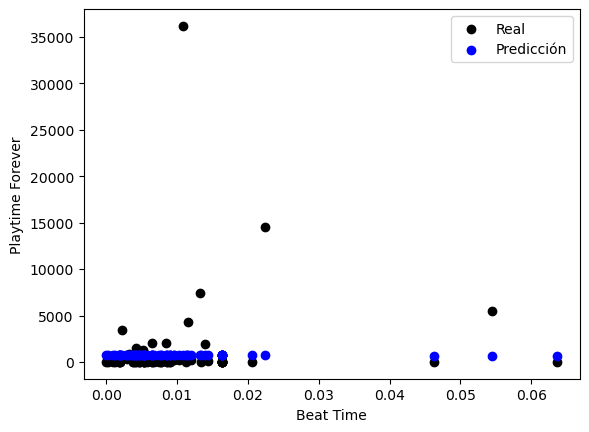

In [29]:
plt.scatter(X_test['beat_time'], y_test, color='black', label='Real')
plt.scatter(X_test['beat_time'], y_pred, color='blue', label='Predicción')
plt.xlabel('Beat Time')
plt.ylabel('Playtime Forever')
plt.legend()
plt.show()

In [30]:
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [-3.08138025e-05 -1.53976571e-01]
Intercept: 725.3420660280829


In [31]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics using the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 22097246.66097534
R-squared: -0.012168586661751135
